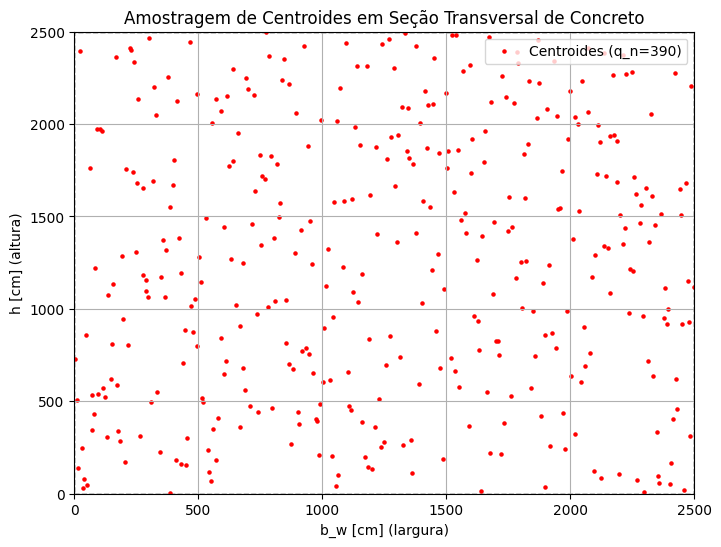

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import qmc

# === Parâmetros de entrada ===
q_n = 390            # Quantidade de pontos (centroides)
b_w_max = 2500       # Largura máxima da seção em cm (eixo x)
h_max = 2500         # Altura máxima da seção em cm (eixo y)

# === Geração dos pontos via Amostragem por Hipercubo Latino ===
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=q_n)

# Escalando os pontos para o domínio da seção de concreto
scaled_sample = qmc.scale(sample, l_bounds=[0, 0], u_bounds=[b_w_max, h_max])

# Separando coordenadas x (largura) e y (altura)
x_centroids = scaled_sample[:, 0]
y_centroids = scaled_sample[:, 1]

# === Plotagem ===
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Amostragem de Centroides em Seção Transversal de Concreto')
ax.set_xlabel('b_w [cm] (largura)')
ax.set_ylabel('h [cm] (altura)')
ax.set_xlim(0, b_w_max)
ax.set_ylim(0, h_max)

# Retângulo da seção
ax.add_patch(plt.Rectangle((0, 0), b_w_max, h_max, fill=False, edgecolor='black', linestyle='--'))

# Plotando os pontos em vermelho
ax.scatter(x_centroids, y_centroids, color='red', s=5, label=f'Centroides (q_n={q_n})')
ax.legend(loc="upper right")

plt.grid(True)
plt.show()

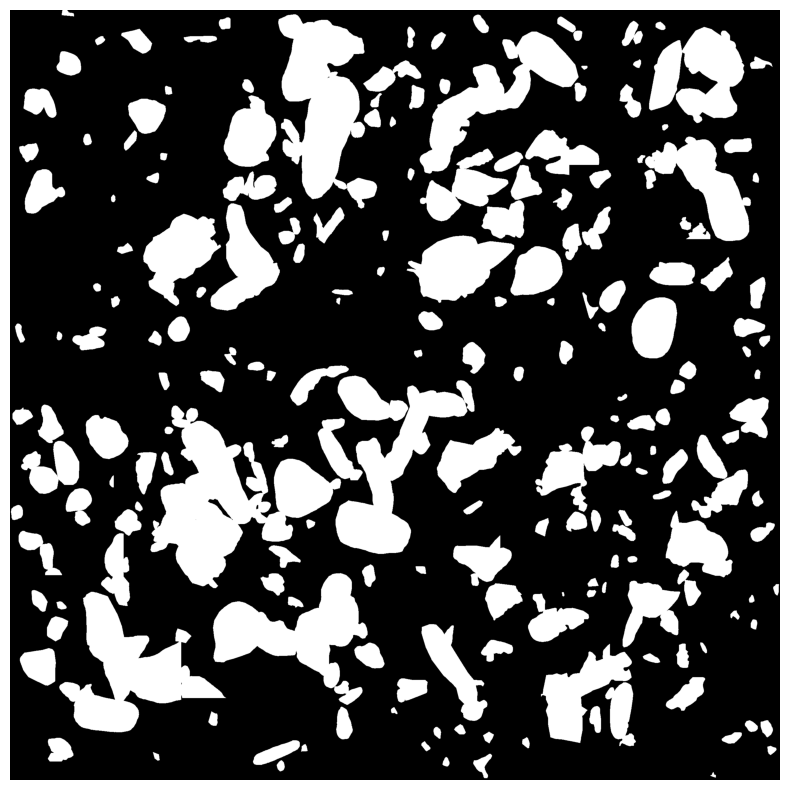

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(2500, 2500), dtype=uint8)

In [10]:
import json
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

def plot_aggregates_randomly(json_path, canvas_size=(2500, 2500), n_objects=390):
    # Carrega o arquivo JSON
    with open(json_path, 'r') as f:
        contour_data = json.load(f)

    canvas = np.zeros(canvas_size, dtype=np.uint8)

    # Seleciona aleatoriamente n_objects contornos (sem repetição)
    all_keys = list(contour_data.keys())
    random.shuffle(all_keys)
    selected_keys = all_keys[:min(n_objects, len(all_keys))]

    # Para cada contorno selecionado, calcula a área
    contours_info = []
    for key in selected_keys:
        x_coords = contour_data[key]["x"]
        y_coords = contour_data[key]["y"]
        if len(x_coords) != len(y_coords):
            continue
        contour = np.array([[x, y] for x, y in zip(x_coords, y_coords)], dtype=np.int32).reshape(-1, 1, 2)
        area = cv2.contourArea(contour)
        contours_info.append((key, area, contour))

    # Ordena os contornos selecionados por área decrescente
    contours_info.sort(key=lambda x: x[1], reverse=True)

    # Plota os contornos no canvas em ordem de área (maior para menor)
    for key, _, contour in contours_info:
        # Bounding box
        x, y, w, h = cv2.boundingRect(contour)

        # Posição aleatória no canvas
        max_x = canvas.shape[1] - w
        max_y = canvas.shape[0] - h
        if max_x <= 0 or max_y <= 0:
            continue
        rand_x = random.randint(0, max_x)
        rand_y = random.randint(0, max_y)

        # Translada o contorno
        translated_contour = contour + np.array([[rand_x - x, rand_y - y]])

        # Desenha o contorno no canvas
        cv2.drawContours(canvas, [translated_contour], -1, 255, -1)

    # Plota o resultado
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas, cmap='gray')
    plt.axis('off')
    plt.show()

    return canvas


plot_aggregates_randomly("new_dataset_contours_aggregate_qd.json")
